# Академия Аналитиков Авито

# Эконометрика

Общий план курса:
- Повторение теории вероятности и математической статистики
- Классическая линейная регрессия
- Множественная регрессия
- Метрики качества регрессии и проверка гипотез, связанных с ней
- Нарушение предпосылок теоремы Гаусса-Маркова
- Модели бинарного выбора
- **Временные ряды**

# Занятие №8

- На предыдущем занятии мы

- Поговорили про метод максимального правдоподобия

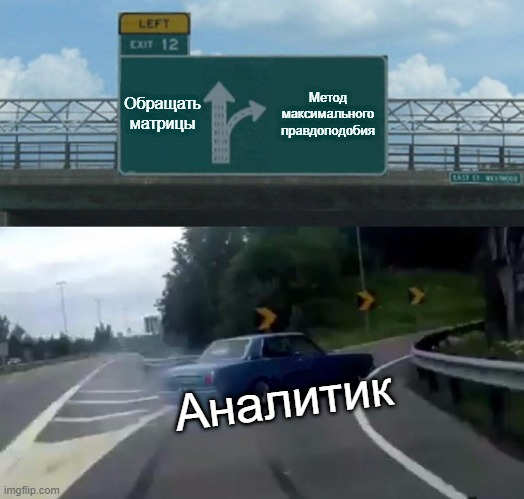

- Рассмотрели модели бинарного выбора

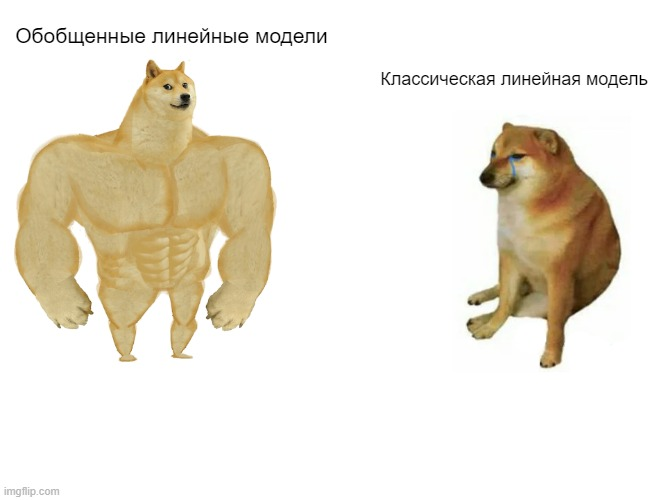

- Попытались оценить качество таких моделей 

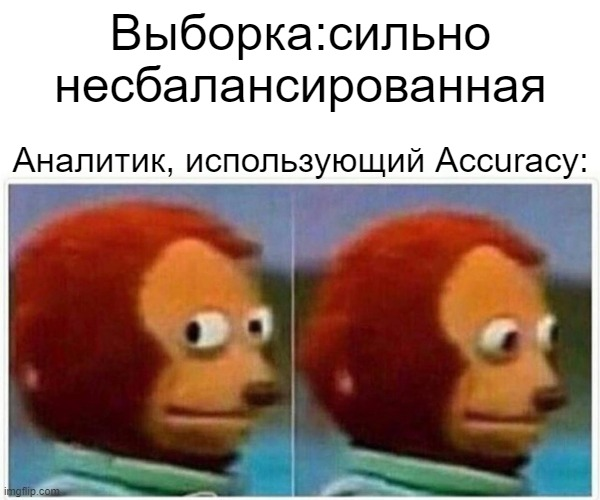

## Повторение

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy as sp

import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf 

import scipy as sp
import seaborn as sns

# Замечательная либа для подключения Yahoo Finance 
import yfinance as yf

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.ar_model import ar_select_order

import warnings
warnings.filterwarnings('ignore')# Чтобы не раздражали

pd.set_option('display.max_columns', None) # Чтобы показывались все колонки
%matplotlib inline

In [4]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [5]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

- Наконец, мы переходим к самому последнему нарушению предпосылок теоремы Г.-М.
- Как обычно, давайте начнем с примера:
    - Строим график (scatter) в координатах Y - X (icecream_sales - income)
    - Фиттим регрессию
    - Накладываем на график полученную регрессию/линию
    - Смотрим на остатки

In [6]:
df = pd.read_csv('practice_08_001.csv')

In [7]:
df.head()

,income,icecream_sales
0,-2.342522,-6.022877
1,5.989382,22.253167
2,3.131914,17.530516
3,-4.025179,-6.999633
4,-0.314401,7.001535


In [11]:
result = smf.ols('icecream_sales ~ income', data=df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         icecream_sales   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     135.6
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           1.80e-29
Time:                        18:35:39   Log-Likelihood:                -4931.9
No. Observations:                1000   AIC:                             9868.
Df Residuals:                     998   BIC:                             9878.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     93.5474      1.169     80.030      0.000      91.254      95.841
income         3.0886      0.265     11.644      0.000       2.568       3.609
==============================================================================
Omnibus:                       44.541   Durbin-Watson:                   0.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.525
Skew:                          -0.520   Prob(JB):                     1.76e-11
Kurtosis:                       3.330   Cond. No.                         4.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
result.predict([[1.0, 2.0]], transform=False)

array([99.72467537])

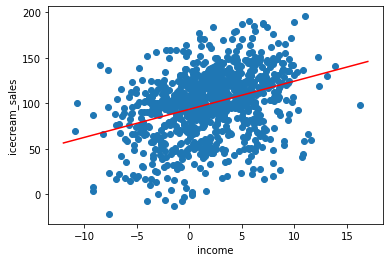

In [23]:
xticks = np.linspace(-12, 17, 1000)
const_arr = np.ones(1000)
inp = np.array([const_arr, xticks]).T
pred = result.predict(inp, transform=False)

plt.scatter(df['income'], df['icecream_sales'])
plt.plot(xticks, pred, c='red')
plt.plot()
plt.xlabel('income')
plt.ylabel('icecream_sales')
plt.show()

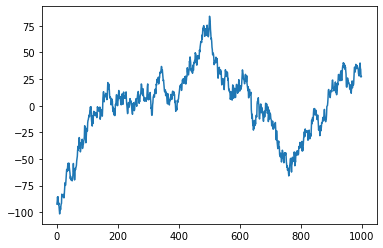

In [24]:
plt.plot(result.resid)

## План
- Автокорреляция
- Одномерные модели временных рядов

## Статические модели

- Эту тему мы с вами немного затрагивали на занятии про гетероскедастичность
- Напомню, что тогда мы обсуждали, что из-за гетероскедастичности у нас возникает проблема с ковариационно-вариационной матрицей
- Раньше, мы могли вместо $var(\epsilon)$ использовать предпосылку, что $var(\varepsilon) = \sigma^2 \cdot I$ и получить, что $var(\hat{\beta}) = \sigma^2 \cdot (X'X)^{-1}$
- Когда мы более не предполгаем гомоскедастичность, $var(\varepsilon) \ne \sigma^2 \cdot I$, дисперсия случайного члена меняется, и мы не можем представить ее в виде матрица с константой на главной диагонали. 
- При автокорреляции новая матрица дисперсий $\Omega$ может быть представлена, как матрица, в которой есть различные элементы побочной диагонали.
- Ну, или вот так: $E(\varepsilon_t, \varepsilon_{t-s}) \ne 0, \text{ где } s > 0$

- Давайте рассмотрим простой теоретический пример:
$$y_t = x'_t \beta + u_t \\
u_t = \rho u_{t-1} + v_t \\ 
v_t \sim i.i.d.(0, \sigma^2_v) \\ 
|\rho| < 1$$
- $E(u_t) = \rho E(u_{t-1}) + E(v_t)$, если мы предположим, что $u_1 = 0$, то с предпосылками о $v_t$, процесс ${u_t}$ стационарен (об этом позже, но тут это значит, что мат. ожидание - константа)  
- $\sigma^2_u = \frac{\sigma^2_v}{1 - \rho^2}$
- $cov(u_t, u_{t-1}) = cov(\rho u_{t-1} + v_t, u_{t-1}) = \rho \sigma^2_u$
- $cov(u_t, u_{t-2}) = cov(\rho u_{t-1} + v_t, u_{t-2}) = cov(\rho^2 u_{t-2} + \rho v_{t-1} + v_t, u_{t-2}) = \rho^2 \sigma^2_u$  
...  
- $cov(u_t, u_{t-s}) = \rho^s \sigma^2_u$
- Итак, вроде проблема какая-то есть. В целом, она такая же, как и с гетероскедастичностью. Состоятельность и несмещенность мы не теряем, а вот эффективность теряется и прогнозы "полетят"

- Но это все искуственный пример и теория. Давайте посмотрим, на что-то более приближенное к реальности

In [54]:
icecream = pd.read_csv('practice_08_002.csv')

- Это недельные данные с 18 марта 1951 г. по 11 июля 1953 г. в США о:
    - `cons`: потребление мороженого на душу населения
    - `income`: усредненный семейный доход в неделю (в долларах США)
    - `price`: цена мороженного (за пинту)
    - `temp`: усредненная температура (в градусах Фаренгейта)

In [55]:
icecream.head()

,cons,income,price,temp
0,0.386,78,0.270,41
1,0.374,79,0.282,56
2,0.393,81,0.277,63
3,0.425,80,0.280,68
4,0.406,76,0.272,69


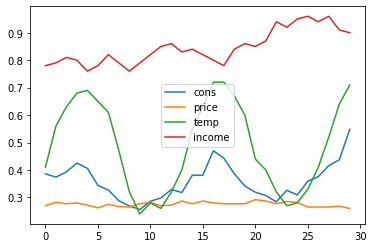

In [56]:
pd.concat([icecream[['cons', 'price']], icecream[['temp', 'income']]/100], axis = 1).plot()
plt.show()

- Неудивительно, что температура явно имеет влияние на потребление мороженого
- Мы можем проверить, насколько именно с помощью нашей старой доброй линейной модели

In [57]:
icecream_model = smf.ols('cons ~ price + temp + income', data = icecream).fit()
icecream_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cons   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     22.17
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           2.45e-07
Time:                        19:22:44   Log-Likelihood:                 58.619
No. Observations:                  30   AIC:                            -109.2
Df Residuals:                      26   BIC:                            -103.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1973      0.270      0.730      0.472      -0.358       0.753
price         -1.0444      0.834     -1.252      0.222      -2.759       0.671
temp           0.0035      0.000      7.762      0.000       0.003       0.004
income         0.0033      0.001      2.824      0.009       0.001       0.006
==============================================================================
Omnibus:                        0.565   Durbin-Watson:                   1.021
Prob(Omnibus):                  0.754   Jarque-Bera (JB):                0.047
Skew:                           0.038   Prob(JB):                        0.977
Kurtosis:                       3.179   Cond. No.                     1.27e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Вот мы получили какие-то коэффициенты и их значимость
- Мы уже видели, что в этих данных явно есть сезонность
- Тогда мы не можем доверять выводам о значимости коэффициентов
- Значит, нам надо проверить:
    - Есть ли автокорреляция
    - Если есть, то побороть ее

### Тестирование на наличие автокорреляции 

- Пожалуй, самым популярным тестом на автокорреляцию первого порядка является тест Дарбина-Уотсона (Durbin, Watson, 1950):
    - Есть следующая статистика: $dw = \frac{\sum_{t=2}^{T}(e_t - e_{t-1})^2}{\sum_{t=1}^{T}e_t^2}$, где $e_t$ - остатки регресии ($y_t - \hat{y}_t$)
    - Мы можем немного переписать эту статистику: $dw \approx 2 - 2 \hat{\rho} \rightarrow \hat{\rho} = 1 - \frac{1}{2}dw$
    - При нулевой гипотезе у нас: $H_0: \rho = 0$, т.е. нет автокорреляции, против альтернативной: $H_1: \rho > 0$
    - Поэтому при нулевой гипотезе $dw \approx 2$
    - Если же $dw \ll 2$, то у нас положительная автокорреляция, т.к. $\rho > 0$, и если $dw \gg 2$, то отрицательная автокорреляция, т.к. $\rho < 0$
- Основной проблемой этого теста является то, что даже при нулевой гипотезе распределение $dw$ зависит не только от объема выборки и кол-ва переменных, но и от фактических значений этих самых переменных
- Из-за этого возникают проблемы с расчетом критических значений для этого теста
- К счастью, можно просто вычислить нижние и верхние границы для критических значений $dw$: $d_L, d_U$:
    - Если $dw < d_L$, то $dw$ точно меньше, чем критическое значение. Значит, нулевая гипотеза отвергается
    - Если $dw > d_U$, то $dw$ точно больше, чем критическое значение. Значит, нулевая гипотеза не отвергается
    - Если $dw$ находится между $d_L, d_U$, то ничего сказать нельзя
- В случае с альтернативной гипотезой: $H_1: \rho < 0$, у нас немного меняются границы. Нижней границей становится $4 - d_L$, а верхней $4 - d_U$
- Если суммировать:  

|Значение статистики dw  |Вывод                                                          |
|------------------------|---------------------------------------------------------------|
|$4 - d_L < dw < 4$      |Нулевая гипотеза отвергается, есть отрицательная автокорреляция|
|$4 - d_U < dw < 4 - d_L$|Неопределенность                                               |
|$d_U < dw < 4 - d_U$    |Нулевая гипотеза не отвергается                                |
|$d_L < dw < d_U$        |Неопределенность                                               |
|$0 < dw < d_L$          |Нулевая гипотеза отвергается, есть положительная автокорреляция|

- Важно, что этот тест предполагает, что регрессоры и ошибки не коррелированы. Поэтому его нельзя применять, когда среди регрессоров есть лагированные значения зависимой переменной

- Давай попробуем применить этот тест на модели, построенной для потребления мороженного
- Если обратиться к табличке с критическими значениями (Durbin, Watson 1950; Savin, White, 1977), то $d_L = 1.21, d_U = 1.65$

In [58]:
# Возьмем остатки из модели
icecream_res = icecream_model.resid.values

In [59]:
# посчитаем статистику DW
numer = np.sum(np.square(icecream_res[1:] - icecream_res[:-1]))
denom = np.sum(np.square(icecream_res))
dw = numer / denom
dw

1.0211697107192037

In [60]:
# Проверим себя
icecream_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cons   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     22.17
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           2.45e-07
Time:                        19:22:47   Log-Likelihood:                 58.619
No. Observations:                  30   AIC:                            -109.2
Df Residuals:                      26   BIC:                            -103.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1973      0.270      0.730      0.472      -0.358       0.753
price         -1.0444      0.834     -1.252      0.222      -2.759       0.671
temp           0.0035      0.000      7.762      0.000       0.003       0.004
income         0.0033      0.001      2.824      0.009       0.001       0.006
==============================================================================
Omnibus:                        0.565   Durbin-Watson:                   1.021
Prob(Omnibus):                  0.754   Jarque-Bera (JB):                0.047
Skew:                           0.038   Prob(JB):                        0.977
Kurtosis:                       3.179   Cond. No.                     1.27e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Значит, нулевая гипотеза отклоняется, т.е. у нас есть автокорреляция
- Так как $dw < d_L$, можно сделать вывод о положительной автокорреляции

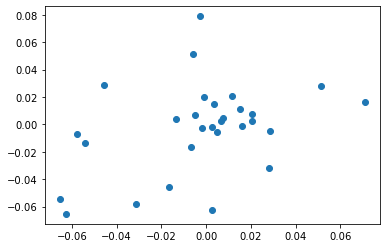

In [61]:
# Нарисуйте график e_{t} на e_{t-1}, e_{t} - остатки модели в момент времени t
plt.scatter(icecream_res[:-1], icecream_res[1:]);

- Есть разные процедуры корректировки
- Мне они не нравятся, и я не рекомендую их выполнять, но для того, чтобы вы знали, что такое есть, распишу одну из них, но выполнять эту процедуру мы не будем

### Оценивание в модели с авторегрессией

- Допустим, мы с вами каким-то образом посчитали $\rho$
- Чтобы избавиться от проблемы с автокорреляции можем вспомнить метод `WLS` и "взвесить наши наблюдения"
- Для момента времени $t \ge 2$:
$$y_t - \rho y_{t-1} = (x_t - \rho x_{t-1})' \beta + v_t$$
- Для $t = 1$:
$$\sqrt{1 - \rho^2}y_1 = \sqrt{1 - \rho^2} x_1' \beta + \sqrt{1 - \rho^2} u_1$$

- Тогда остается вопрос, а как нам посчитать $\rho$

- Процедура Кохрейна-Оркатта (Cochrane-Orcutt)
    - считаем МНК регрессию
    - достаем из ее остатки $e$
    - считаем регрессию $e_t = \rho e_{t-1} + v_t$
    - получаем $\hat{\rho}$
    - преобразовываем исходное уравнений и считаем новую регрессию
    - повторояем шаги, начиная с п.1
- То есть это итеративная процедура, которая останавливается тогда, когда $\hat{\rho}$ мало отличается от предыдущего

- Однако, результаты подобной процедуры не сопоставимы с их аналогами из обычной регрессии
- Но можно убедиться, являются, ли коэффициенты статистически значимыми

- Наличие автокорреляции может быть признаком того, что модель в чем-то некорретна, например, некорректен функциональный вид или динамическая спецификация
- Поэтому, вместо каких-то процедур изменения оценок коэффициентов, по моему мнению, лучше будет подумать над изменением спецификации модели

## Динамические модели

- Очень важно, разделять два случая:
$$y_t = \alpha + \beta_1 x_t + \beta_2 x_{t-1} + u_t \\ 
y_t = \alpha + \beta_1 x_t + \beta_2 y_{t-1} + u_t$$  
- Мы считаем, что $x_t$ детерминированы, т.е. они не коррелируют с ошибками модели (лаги $x_t$ в том числе не коррелируют)
- Поэтому первую модель можно спокойно посчитать с помощью МНК
- А вот со второй моделью дело обстоит иначе
- Даже если бы у нас не было автокорреляции (т.е. $u_t$ не были бы автокоррелированы), строго говоря, включение лаговой зависимой переменной привело бы к смещению коэффициентов. Однако, зачастую такого рода смещение игнорируется
- Только вот если $u_t$ коррелированы, и мы включили лаговую зависимую переменную, то наши оценки коэффициентов будут не только смещенными, но и не состоятельными
- Про вторую модель мы еще поговорим чуть дальше. Давайте попробуем пометь нашу модель для потребления мороженого, включив в нее лаг температуры

In [ ]:
icecream['temp_prev'] = icecream['temp'].shift()

In [ ]:
icecream_model_lagged = smf.ols('cons ~ price + temp + income + temp_prev', data = icecream).fit()
icecream_model_lagged.summary()

- Видим, что $dw = 1.582$, т.е. мы попали теперь из зоны положительной автокорреляции в зону неопределенности
- Но если начать додумывать, то это значение статистики ближе к верхней границе, поэтому мы можем предпочесть не отвергать нулевую гипотезу об отсутствии автокорреляции

- А теперь к второй модели
- Допустим мы ее посчитаем

In [ ]:
icecream['cons_prev'] = icecream['cons'].shift()

In [ ]:
icecream_model_lagged_y = smf.ols('cons ~ price + temp + income + cons_prev', data = icecream).fit()
icecream_model_lagged_y.summary()

- Как мы видим, тут выводится статистика DW, но, к сожалению, мы больше не можем ей доверять, когда у нас лаг $y$ является регрессором
- Чтобы понять, есть ли автокорреляция в такой модели, можно воспользоваться тестом Бройша-Годфри (Breusch–Godfrey):
    - $H_0: \rho_1 = \rho_2 = ... = \rho_p = 0$
    - считаем регрессию и получаем остатки $e$
    - считаем регрессию остатков на все объясняющие переменные и лаги остатков: $e_t = \alpha_1 + \alpha_2 X_t + \rho_1 e_{t-1} + \rho_2 e_{t-2} + ... + \rho_p e_{t-p} + v_t$
    - берем $R^2$ из этой дополнительной (auxiliary) регрессии
    - считаем статистику $BG = (n-p)R^2 \sim \chi_p^2$

In [ ]:
# достаем остатки
res_lagged_y =

In [ ]:
# регрессируем остатки на регрессоры из первоначальной модели, включая лаг зависимой переменной
# давайте считать, что мы пытаемся "поймать" лаг первого порядка
bg_model = 

In [ ]:
# посчитаем статистику
BG = 

In [ ]:
# посчитаем p-value


In [ ]:
# проделаем то же самое, для модели с лагом температуры
bg_model_lagged_x = 


## Промежуточные итоги

- Мы с вами посмотрели, что автокорреляция хоть не делает оценки коэффициентов несмещенными или несостоятельными, но делает их более не эффективными
- Научились тестировать на наличие автокорреляции
- Узнали, что есть процедура(-ы) корректировки коэффициентов
- Но самое главное, это то, что автокорреляция это скорее следствие какой-то более серьезной проблемы, например, некорректная спецификация модели. И именно с этой проблемой надо бороться в первую очередь
- Узнали, что добавление лагов регрессоров не страшно, а вот лагов зависимой переменной может привести к потере состоятельности оценок
- Посмотрели на тест Бройша-Годфри, который может быть применен к любой модели, включая модели с лагом зависимой переменной
- Из важного мы забыли рассмотреть на другой алгоритм расчета стандартных ошибок. Так называемые, `HAC (Heteroskedasticity and Autocorrelation Consistent) estimators`. Мы про них говорили на занятии про гетероскедастичность

## Одномерные модели временных рядов

- Такс, давайте продолжим рассматривать пример, когда у нас есть только один процесс ${y_t}$. Упростим, выкинув $X_t$
- Итак, сначала нужно сказать, что такое стационарность

- Стационарность - это такое замечательное свойство, что средние, дисперсии и ковариации ряда не зависят от ряда:
    - $E(y_t) = \mu < \infty$
    - $var(y_t) = E((y_t - \mu)^2) = \gamma_0$
    - $cov(y_t, y_{t-k}) = E\{(y_t - \mu)(y_{t-k} - \mu)\} = \gamma_k$
- Собственно, это определение слабой стационарности или ковариационной стационарности

- А как вообще выглядит нестационарный и стационарный ряды?

In [ ]:
stationary = []
nonstationary = []

for i in range(1000):
    if i == 0:
        stationary.append(np.random.normal(loc = 0, scale = 1, size = 1))
    else:
        stationary.append(1 + 0.99*stationary[i-1] + np.random.normal(loc = 0, scale = 1, size = 1))

for i in range(1000):
    if i == 0:
        nonstationary.append(np.random.normal(loc = 0, scale = 1, size = 1))
    else:
        nonstationary.append(1 + nonstationary[i-1] + np.random.normal(loc = 0, scale = 1, size = 1))

In [ ]:
plt.plot(pd.concat([pd.Series(stationary, name = 'stationary'), 
                    pd.Series(nonstationary, name = 'nonstationary')], 
                   axis = 1))
plt.legend(['stationary', 'nonstationary'])
plt.show()

- Ну, что же, кажется работать с рядом, который не "взрывается" со временем, работать лучше
- Вторая важная вещь - это автокорреляционная функция (коррелограмма). На самом деле это очень простая концепция, которая показывает корреляцию во времени между $y_t$:  
$$\rho_k = \frac{cov(y_t, y_{t-k})}{var(y_t)} = \frac{\gamma_k}{\gamma_0}$$  
- Из автокорреляционной функции мы можем сделать вывод о степени коррелированности одной из величин процесса с предшествующими величинами, и, таким образом, продолжительность и силу памяти процесса

In [ ]:
plot_acf(np.array(stationary))
plt.show()

In [ ]:
plt.plot(stationary)
plt.show()

- Собственно стационарный процесс был построен таким образом, что: $y_t = 1 + 0.99 \cdot y_{t-1} + v_t$, поэтому неудивительно, что ACF так медленно затухает 

### Общие процессы ARMA

- Мы рассмотрим следующие основные процессы:
    - $MA(q): y_t = \alpha_1 u_{t-1} + \alpha_2 u_{t-2} + ... + \alpha_q u_{t-q} + u_t$
    - $AR(p): y_t = \beta_1 y_{t-1} + \beta_2 y_{t-2} + ... + \beta_p y_{t-p} + u_t$
    - $ARMA(p, q): y_t = \beta_1 y_{t-1} + \beta_2 y_{t-2} + ... + \beta_p y_{t-p} + \alpha_1 u_{t-1} + \alpha_2 u_{t-2} + ... + \alpha_q u_{t-q} + u_t$
- Для удобства введем обозначение лаг оператора: $Ly_t = y_{t-1}$

- Думаю, вы заметили, что ранее мы с вами уже несколько раз видели $AR(1)$ процесс
- А чуть выше видели его график и ACF
- Давайте посмотрим на $MA(1)$ и $ARMA(1, 1)$ процессы

In [ ]:
eps = np.random.normal(loc = 0, scale = 1, size = 1000)

In [ ]:
ma = []
for i in range(1000):
    if i == 0:
        ma.append(eps[i])
    else:
        ma.append(eps[i] + 0.5 * eps[i-1])

In [ ]:
plt.plot(pd.Series(ma, name = 'MA(1)'))
plt.legend(['MA(1)'])
plt.show()

In [ ]:
plot_acf(np.array(ma))
plt.show()

In [ ]:
arma = []
for i in range(1000):
    if i == 0:
        arma.append(eps[i])
    else:
        arma.append(eps[i] + 0.5 * arma[i-1] + 0.5 * eps[i-1])

In [ ]:
plt.plot(pd.Series(arma, name = 'ARMA(1)'))
plt.legend(['ARMA(1)'])
plt.show()

In [ ]:
plot_acf(np.array(arma))
plt.show()

### ARIMA

- Тем не менее, на практике нам не всегда будут встречаться стационарные временные ряды.
- Надо бы подумать над тем:
    - Как тестировать на стационарость
    - Если ряд не стационарен, можно ли его привести к стационарному

- Есть два основных теста на стационарность
- Первый, наиболее распространенный, был предложен Д. Дики и В. Фуллером (Dickey and Fuller, 1979):
    - Допустим, у нас есть такая модель: $y_t = \alpha + \beta \cdot y_{t-1} + \gamma \cdot t + \varepsilon_t$
    - Тогда преобразуем выражение в виде разностей: $\Delta{y_t} = \alpha + (\beta - 1)y_{t-1} + \gamma \cdot t + \varepsilon_t$
    - $\Delta{y_t} = y_{t} - y_{t_1}$, ряд будет нестационарен, если $\beta - 1 = 0$ или\и $\gamma \ne 0$
    - Причем, в первом случае мы скажем, что ряд стационарен в разностях, а во втором, что присутсвует трендовая стационарность
    - Стационарен в разностях означает, что если у нас есть ряд $x_t$, который не является стационарным, то при вычитании из этого ряда его лагированных значений, мы получим стационарный ряд, т.е. $\Delta{x_t} = x_t - x_{t-1}$ будет стационарным
    - Трендовая стационарность означает, что ряд можно сделать стационарным, если "очистить" от тренда. Надо понимать, что случай выше, это случай линейного тренда. Есть разные зависимости от тренда. Чтобы достичь трендовой стационарности, достаточно добавить в качестве объясняющей переменной тренд и\или функцию от него.
    - На самом деле, сейчас используется немного модифицированный тест Дики-Фуллера, т.к. оригинальный тест требовал, чтобы случайный член не обладал автокорреляцией. Называется он расширенным тестом Дики-Фуллера (ADF)
    - Таким образом, нулевая гипотеза для ADF теста: у ряда есть единичный корень (т.е. ряд не стационарен)
- Второй тест был предложен группой авторов, Квятковски, Филлипс, Шмидт и Шин (Kwiatkowski, Phillips, Schmidt, Shin, 1992). Будем называть его KPSS тест. 
    - Нулевая гипотеза этого теста отличается от нулеваой гипотезы ADF теста. В KPSS тесте нулевой гипотезой является (тренд) стационарность. 
    - Основная идея состоит в том, что временной ряд разлагается на сумму детерминированного временного тренда, случайного члена и стационарного (остаточного) члена ошибки (обычно не белый шум). 
    - Делаем вспомогательную регрессию $y_t = \alpha + \gamma \cdot t + \varepsilon_t$
    - Сохраняем остатки $e_t$
    - Считаем сумму остатков: $S_t = \sum{e_t}$
    - $KPSS = \frac{S^2_t}{\hat{\sigma}^2}$
    - Если мы хотим проверить нулевую гипотезу о тренд стационарности, то делаем, как описано выше, если хотим проверить стационарность в разностях, то тренд надо исключить из вспомогательной регрессии

In [ ]:
sp500 = yf.download('SPY', period = '3y')

In [ ]:
sp500.head()

In [ ]:
sp500 = sp500['Adj Close']
sp500 = sp500.rename('S&P500')

In [ ]:
sp500.plot(figsize=(10, 10))

plt.title('Индекс S&P500')

plt.ylabel('Скорректированная цена закрытия')
plt.xlabel('Дата')

plt.grid()

plt.show()

- Допустим, мы хотим больше финансовых инстурментов

In [ ]:
tickers = ['AAPL', 'TSLA', 'GOOG', 'MSFT']

In [ ]:
data_many_stocks = pd.DataFrame(columns=tickers)

In [ ]:
for ticker in tickers:
    data_many_stocks[ticker] = yf.download(ticker, period = '3y')['Adj Close']

In [ ]:
data_many_stocks = data_many_stocks.dropna()

In [ ]:
data_many_stocks

In [ ]:
data_w_index = pd.concat([data_many_stocks, sp500], axis = 1).dropna()

In [ ]:
# Plot all the close prices
((data_w_index.pct_change()+1).cumprod()).plot(figsize=(10, 10))

# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("Скорректированные цены закрытия")

plt.ylabel('Цена')
plt.xlabel('Дата')

# Plot the grid lines
plt.grid()
plt.show()

In [ ]:
adf_test(sp500)

In [ ]:
kpss_test(sp500)

- Отлично, мы узнали, как тестировать временные ряды на стационарность, и обнаружили, что ряд цен на акции не является стационарным рядом.
- Что делать дальше?
- Давайте проверим, является ли ряд стационарным в разностях, т.е. вычтем лагированные значения

In [ ]:
delta_index = (sp500 - sp500.shift()).dropna()

In [ ]:
adf_test(delta_index)

In [ ]:
kpss_test(delta_index)

- Ну что же, мы видим, что взятие разностей очень помогло. Ряд стал стационарным.
- В большинстве случаев, этого достаточно. Однако раз уж я решил вам показать цены акций, то немного окунемся в количественные финансы и финансовую эконометрику (совсем чуть чуть)
- Абсолютная разница цен не имеет особого смысла, да и не обладает хорошими статистическими свойствами. Поэтому эту разницу еще делят на значение цены предыдущего периода. Получаем доходность, с которой уже можно работать, как в плане теории (*почти* вся финансовая теория построено именно вокруг доходностей), так и в плане моделей (доходности обладают хорошими статистическими свойствами)

In [ ]:
index_ret = sp500.pct_change().dropna()

In [ ]:
index_ret.plot(figsize = (12, 10))

plt.title('Доходность индекса S&P500')

plt.xlabel('Дата')
plt.ylabel('Доходность')

plt.show()

In [ ]:
plot_acf(index_ret)
plt.show()

In [ ]:
plot_pacf(index_ret)
plt.show()

### Выбор модели

- Итак, мы научились тестировать на стационарность, а затем приводить к стационарности, если потребуется
- Однако, мы не знаем, сколько лагов нам брать. ARMA(1, 2)? ARMA(0, 2)? ARMA(5, 100)?
- Чаще всего, на практике используют либо критерий Акаике (Akaike, 1973) - AIC, либо байесовский информационный критерий Шварца (Schwarz, 1978) - BIC. Мы с вами уже видели эти критерии ранее
- Давайте начнем с трех моделей (считаем, что ряд привели к стационарности)
    - ARMA(1, 0), т.е. AR(1)
    - ARMA(0, 1), т.е. MA(1)
    - ARMA(1, 1)

In [ ]:
ar = ARIMA(endog=index_ret, order = (1, 0, 0)).fit()
ma = ARIMA(endog=index_ret, order = (0, 0, 1)).fit()
arma = ARIMA(endog=index_ret, order = (1, 0, 1)).fit()

In [ ]:
print(ar.summary())

- Важным тестом для диагностики моделей временных рядов также является тест Льюнга—Бокса (Ljung, Box, 1978)
- Он проверяет, что автокорреляции статистически равны нулю
- Статистика выглядит так: $Q_k = T \cdot (T+2) \cdot \sum_{k=1}^K \frac{1}{T-k} \cdot \rho^2_{k}$

In [ ]:
acorr_ljungbox(ar.resid, return_df=True)

In [ ]:
plt.plot(ar.resid)
plt.show()

In [ ]:
print(ar.aic, ma.aic, arma.aic)

In [ ]:
print(ar.bic, ma.bic, arma.bic)

- Мда, такое себе, честно говоря.
- Увеличим количество рассматриваемых моделей. К сожалению, в `statsmodels` нет такой замечательной функции, которая бы автоматически перебрала все возможные комбинации лагов (в `R` есть функция `auto.arima()` в пакете `forecast`. Да и вообще, советую почитать этот [учебник](https://otexts.com/fpp2/))
- Будем использовать, что есть. Для начала посмотрим, на лучший AR() лаг

In [ ]:
ar_select_order(index_ret, maxlag=13).ar_lags

- То есть нам лучше вообще не использовать AR() часть... Хотя до этого мы видели, что модель с AR(1) частью была лучшей среди прочих ARMA() моделей. В целом, такое может быть, так как в `ar_select_order` используется более сложный алгоритм выбора (наверное). Почитать можно [тут](https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.ar_select_order.html?highlight=ar_select)
- Перейдем к MA() части

In [ ]:
q = 5
tmp = np.empty(q)
for i in range(q):
    tmp[i] = ARIMA(index_ret, order = (0, 0, i)).fit().aic
best_q = np.argmin(tmp)

In [ ]:
best_arima = ARIMA(index_ret, order = (0, 0, best_q)).fit()

In [ ]:
print(best_arima.summary())

In [ ]:
acorr_ljungbox(best_arima.resid, return_df=True)

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(best_arima.resid)
plt.show()